### Avaliação
As submissões são avaliadas pela área sob a curva ROC entre a probabilidade prevista e o alvo observado.

- Wiki sobre a [curva ROC](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor)

### Importando as bibliotecas

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from roc_plot import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

STATE = 42

### Path dos dados processados

In [4]:
train = '../../data/processed/train_pro.csv'
test = '../../data/processed/test_pro.csv'

train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

- Trazendo os `id`, pois, é necessário para enviar a validação para o Kaggle

In [5]:
id_path = '../../data/raw/test.csv'
id_df = pd.read_csv(id_path)
id = id_df['id']

In [6]:
id

0         165034
1         165035
2         165036
3         165037
4         165038
           ...  
110018    275052
110019    275053
110020    275054
110021    275055
110022    275056
Name: id, Length: 110023, dtype: int64

- Verficando os datasets

In [7]:
test_df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,GeographyFrance,GeographyGermany,GeographySpain,GenderMale,OptimalClient
0,-5.837575,-3.84,2,0.0,2,0.0,1.0,-1.464915,1,0,0,0,0
1,-5.829979,-3.61,2,0.0,1,1.0,0.0,-1.464928,1,0,0,0,0
2,-5.832093,-3.73,7,0.0,2,1.0,0.0,-1.464918,1,0,0,0,0


In [8]:
train_df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,GeographyFrance,GeographyGermany,GeographySpain,GenderMale,OptimalClient,Exited
0,0.079646,-0.4,3,0.0,2,1.0,0.0,0.788698,1,0,0,1,0,0
1,-0.283186,-0.4,1,0.0,2,1.0,1.0,-0.850085,1,0,0,1,1,0
2,0.168142,0.3,10,0.0,2,1.0,0.0,0.831134,1,0,0,1,0,0


- Separandos as features e target

- `X` features 
- `y` target

In [9]:
X = train_df.drop(columns='Exited')
y = train_df['Exited']

### Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=STATE)

## Modelos Padrões

### Regressão logística

In [11]:
model_lr = LogisticRegression(random_state=STATE)

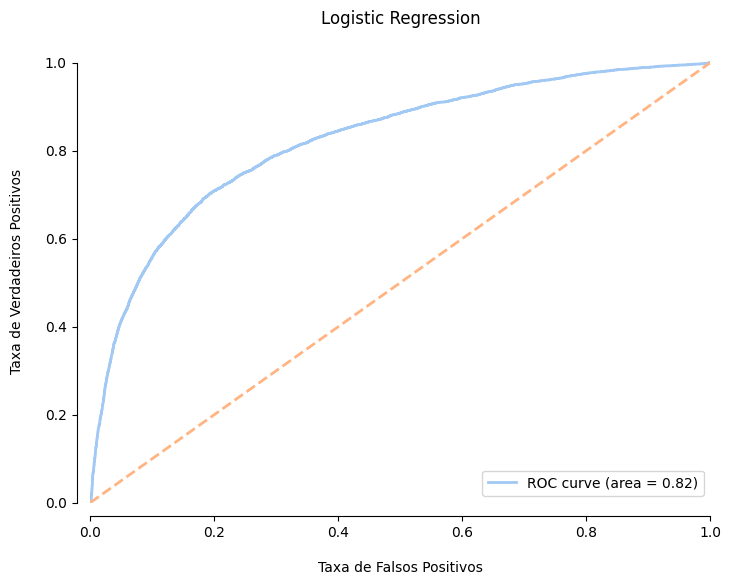

In [14]:
roc_lr = plot_roc_curve(model_lr, X_train, X_test, y_train, y_test, "Logistic Regression")

### Random Forest

In [15]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=STATE)

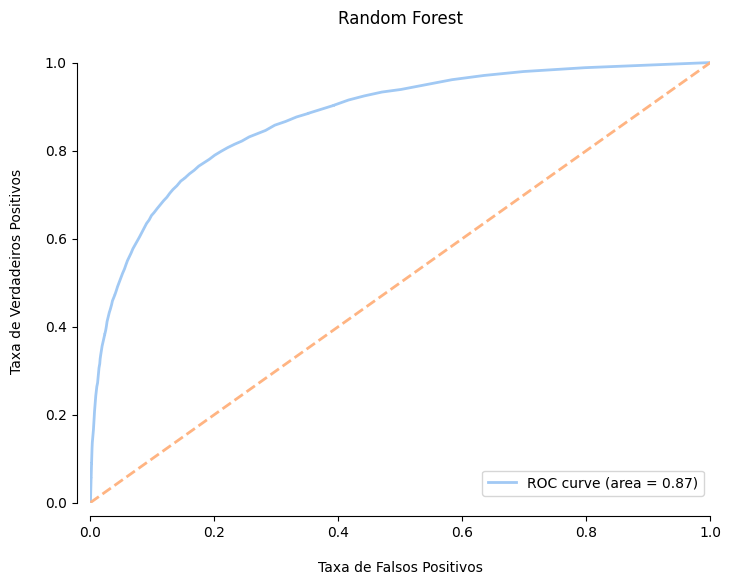

In [16]:
roc_rf = plot_roc_curve(model_rf, X_train, X_test, y_train, y_test, "Random Forest")

### Gradient Boosting

In [17]:
model_gbc = GradientBoostingClassifier(random_state=STATE)

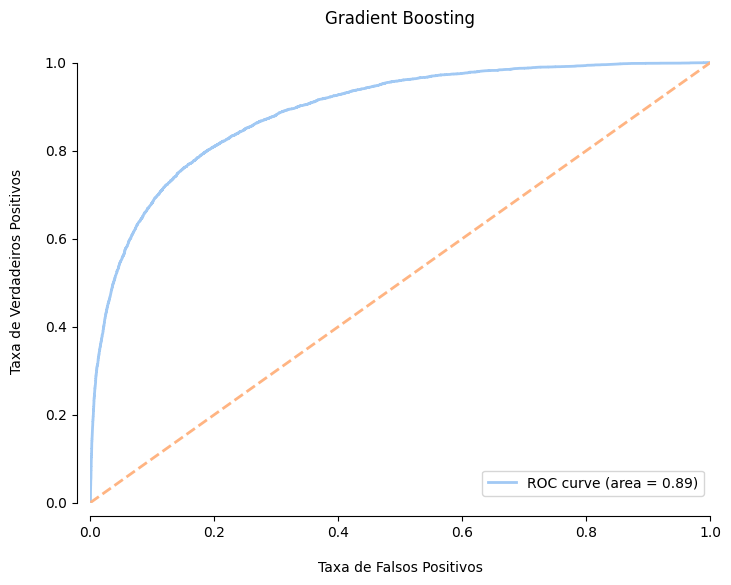

In [18]:
roc_gbc = plot_roc_curve(model_gbc, X_train, X_test, y_train, y_test, "Gradient Boosting")

### MLP Classifier

In [19]:
model_mlp = MLPClassifier(random_state=STATE, max_iter=10000, learning_rate='adaptive')

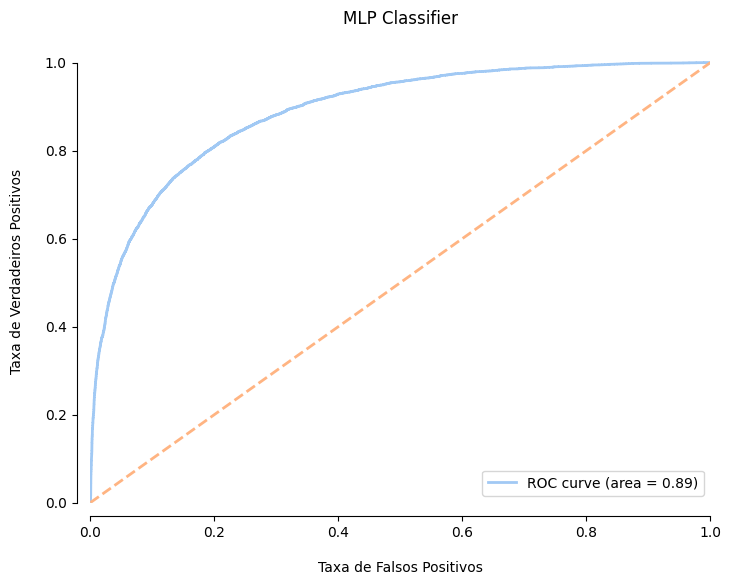

In [20]:
roc_mlp = plot_roc_curve(model_mlp, X_train, X_test, y_train, y_test, "MLP Classifier")

## Modelos com hiperparâmetros

- Função para tunar e plotar ROC curve usando `GridSearchCV `e `Pipeline`

- Configuração do KFold



In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state=STATE)

In [13]:
def tune_model(model, param_grid, model_name):
    pipeline = Pipeline([ 
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")
    
    return best_model

### Parâmetros para Regressão logística

In [18]:
lr = 'Regressão logística'

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],  # Parâmetro de regularização com mais valores
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],  # Adicionando 'elasticnet' e 'none'
    'classifier__solver': ['liblinear'],
    'classifier__l1_ratio': [0.15, 0.5]  # Proporção de L1 na penalidade 'elasticnet'
}

best_model_lr = tune_model(LogisticRegression(max_iter=1000, random_state=STATE), param_grid_lr, lr)

Melhores parâmetros para Regressão logística: {'classifier__C': 0.1, 'classifier__l1_ratio': 0.15, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


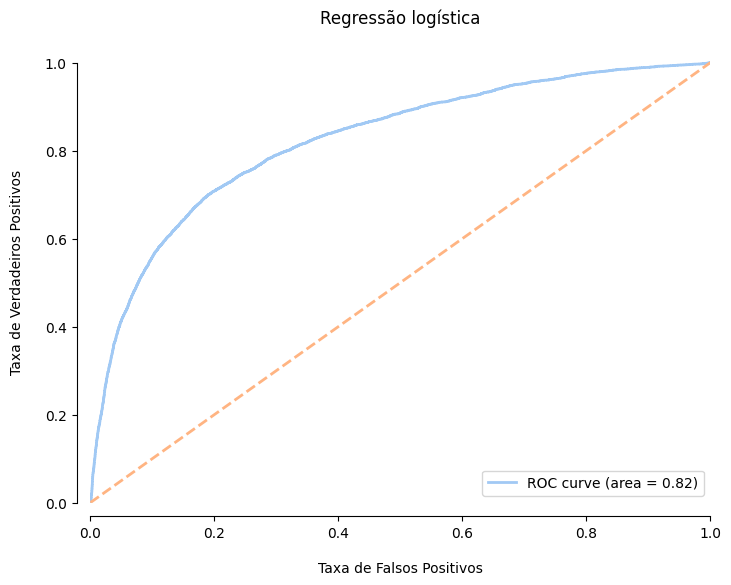

In [19]:
tune_lr = plot_roc_curve(best_model_lr, X_train, X_test, y_train, y_test, lr)

- Infelizmente, não conseguimos nenhuma melhoria no modelo, que permanece com uma precisão de cerca de 82%, mesmo após a otimização.

### Parâmetros para Random Forest

In [27]:
rf = "Random Forest"

param_grid_rf = {
    'classifier__n_estimators': [200, 250],
    'classifier__max_depth': [8, 10],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [4, 5]
}
best_model_rf = tune_model(RandomForestClassifier(), param_grid_rf, rf)

Melhores parâmetros para Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250}


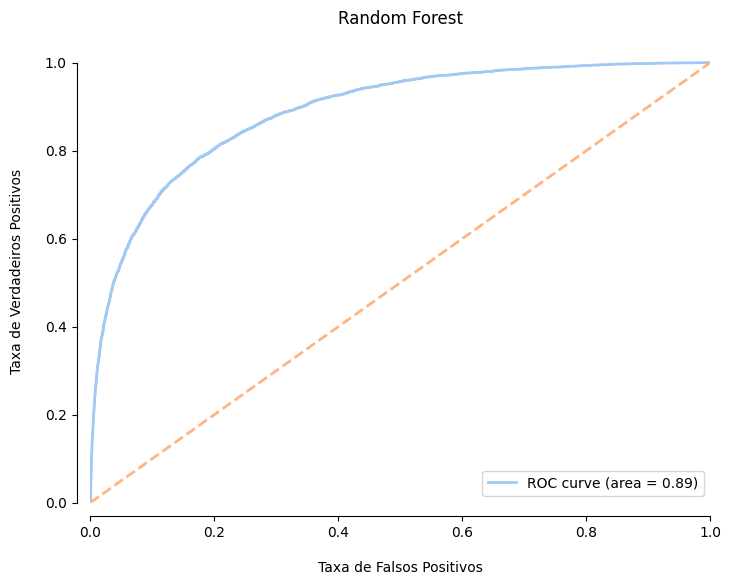

In [28]:
tune_rf = plot_roc_curve(best_model_rf, X_train, X_test, y_train, y_test, rf)

- Novamente, não conseguimos nenhum ganho de perfomace, provavelmente, não conseguiremos superar os 90%

### Parâmetros para MLPClassifier

In [29]:
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(100, 50), (50, 50)],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.01],
    'classifier__learning_rate': ['adaptive']
}
best_model_mlp = tune_model(MLPClassifier(max_iter=100), param_grid_mlp, "MLP Classifier")

Melhores parâmetros para MLP Classifier: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'sgd'}


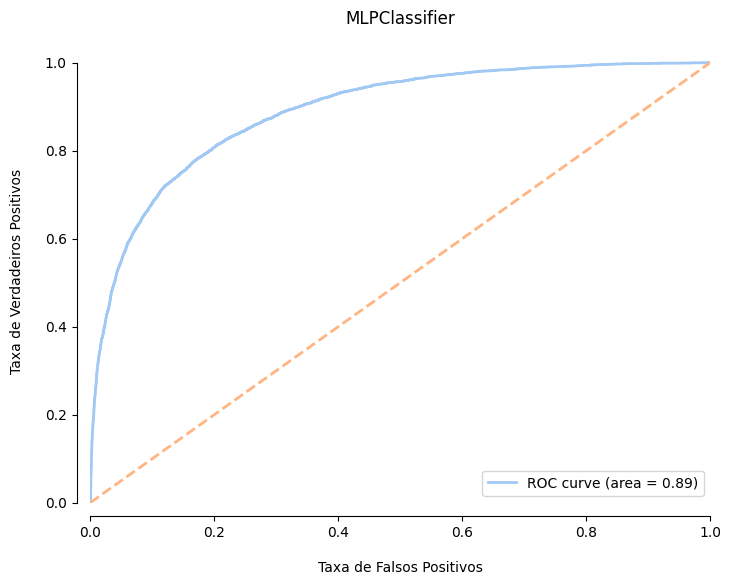

In [30]:
tune_mlp = plot_roc_curve(best_model_mlp, X_train, X_test, y_train, y_test, "MLPClassifier")

- Usaremos os modelos Random Forest e MLPClassifier para validar nossos dados, ambos alcaçaram os 89%

## Dataset de Validação

### Random Forest Resultados

In [92]:
prediction_lr = best_model_lr.predict(test_df)

- Fazendo a cópia do dataframe original

In [93]:
test_rf = test_df.copy()

In [94]:
test_rf['Exited'] = prediction_lr
test_rf['id'] = id

- Modelo de envio

In [95]:
submission_rf = test_rf[['id', 'Exited']]

In [96]:
submission_rf

,id,Exited
0,165034,0
1,165035,0
2,165036,0
3,165037,0
4,165038,0
...,...,...
110018,275052,0
110019,275053,0
110020,275054,0
110021,275055,0


In [97]:
submission_rf.to_csv('../../data/predict/submissionRF.csv', index=False)

### MLP Resultados

In [102]:
prediction_mlp = best_model_mlp.predict(test_df)

- Fazendo a cópia do dataframe original

In [103]:
test_mlp = test_df.copy()

In [104]:
test_mlp

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,GeographyFrance,GeographyGermany,GeographySpain,GenderMale,OptimalClient
0,-5.837575,-3.84,2,0.000000,2,0.0,1.0,-1.464915,1,0,0,0,0
1,-5.829979,-3.61,2,0.000000,1,1.0,0.0,-1.464928,1,0,0,0,0
2,-5.832093,-3.73,7,0.000000,2,1.0,0.0,-1.464918,1,0,0,0,0
3,-5.830135,-3.71,8,0.000000,1,1.0,0.0,-1.464922,1,0,0,1,0
4,-5.824575,-3.69,10,0.000008,1,1.0,0.0,-1.464918,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,-5.838828,-3.78,7,0.000008,1,1.0,1.0,-1.464917,0,0,1,1,0
110019,-5.838437,-3.71,4,0.000012,1,1.0,1.0,-1.464933,1,0,0,0,0
110020,-5.827708,-3.76,2,0.000000,2,1.0,0.0,-1.464937,1,0,0,1,0
110021,-5.827943,-3.75,3,0.000000,1,1.0,1.0,-1.464915,1,0,0,0,0


In [105]:
test_mlp['Exited'] = prediction_mlp
test_mlp['id'] = id

In [106]:
test_mlp

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,GeographyFrance,GeographyGermany,GeographySpain,GenderMale,OptimalClient,Exited,id
0,-5.837575,-3.84,2,0.000000,2,0.0,1.0,-1.464915,1,0,0,0,0,0,165034
1,-5.829979,-3.61,2,0.000000,1,1.0,0.0,-1.464928,1,0,0,0,0,0,165035
2,-5.832093,-3.73,7,0.000000,2,1.0,0.0,-1.464918,1,0,0,0,0,0,165036
3,-5.830135,-3.71,8,0.000000,1,1.0,0.0,-1.464922,1,0,0,1,0,1,165037
4,-5.824575,-3.69,10,0.000008,1,1.0,0.0,-1.464918,0,1,0,1,0,1,165038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,-5.838828,-3.78,7,0.000008,1,1.0,1.0,-1.464917,0,0,1,1,0,0,275052
110019,-5.838437,-3.71,4,0.000012,1,1.0,1.0,-1.464933,1,0,0,0,0,0,275053
110020,-5.827708,-3.76,2,0.000000,2,1.0,0.0,-1.464937,1,0,0,1,0,0,275054
110021,-5.827943,-3.75,3,0.000000,1,1.0,1.0,-1.464915,1,0,0,0,0,0,275055


- Modelo de envio

In [108]:
submission_mlp = test_mlp[['id', 'Exited']]

In [109]:
submission_mlp

,id,Exited
0,165034,0
1,165035,0
2,165036,0
3,165037,1
4,165038,1
...,...,...
110018,275052,0
110019,275053,0
110020,275054,0
110021,275055,0


In [110]:
submission_mlp.to_csv('../../data/predict/submissionMLP.csv', index=False)

- E assim terminamos a nossa predição.